In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import scipy.io as sio
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 4. Taiwanese Bankruptcy Prediction dataset #

## SVM with the RBF Kernel ##

In [2]:
# Calculate error given feature vectors X and labels Y
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e


# Draw the heatmap of training errors
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize = (6,5))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel = r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Cross-validation error wrt $C$ and $\gamma$')
    ax.invert_yaxis()
    plt.xticks(rotation=45)
    plt.show()

In [3]:
# Bankruptcy dataset
# 20-80 partition
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:1363]                         # Shape: (1363, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:1363]                         # Shape: (1363, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[1363:]                         # Shape: (5456, 2)
Y_test  = Y[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Note: you may need to restart the kernel to use updated packages.
(1362, 2)
(1362,)
(5456, 2)
(5456,)


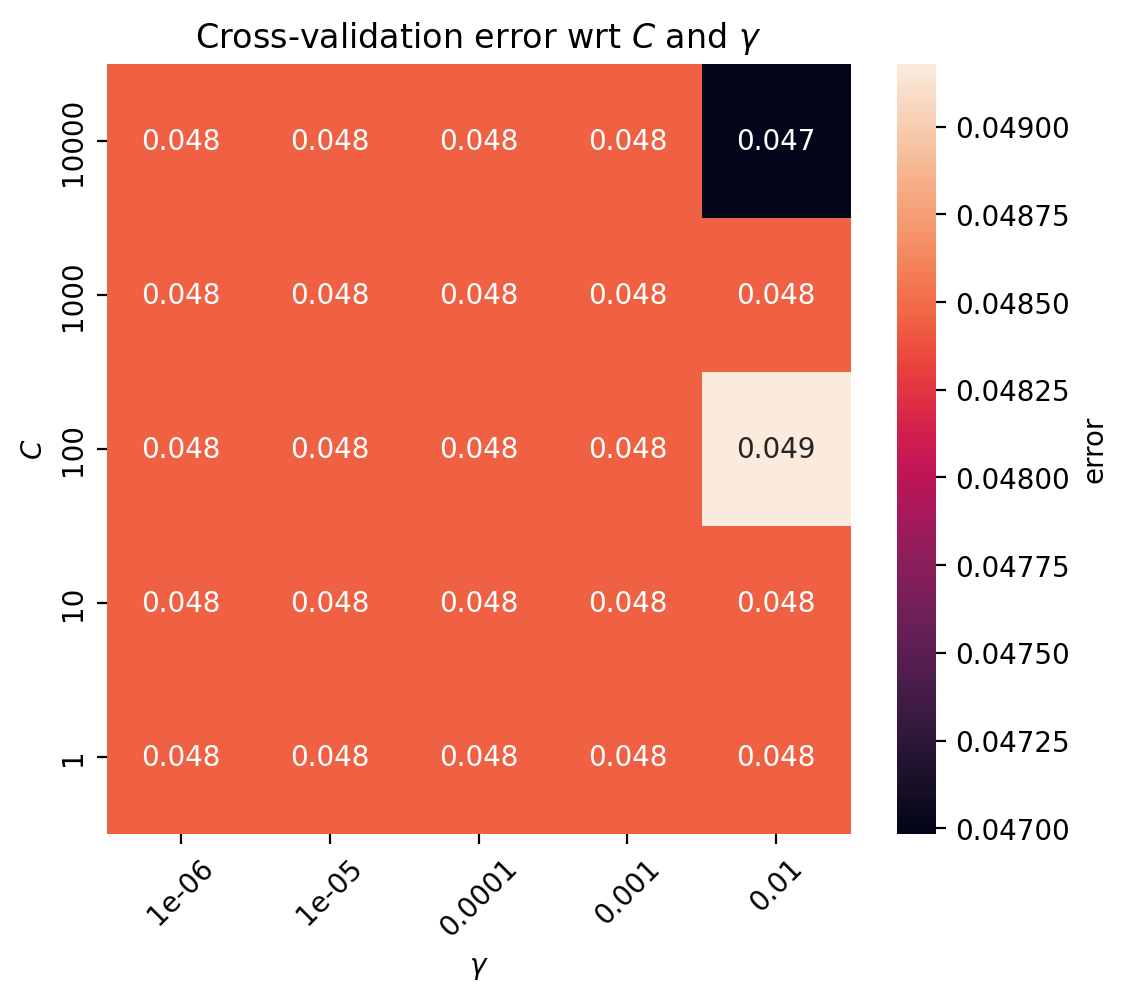

Best CV error = 0.046983408748114616
C* = 10000
gamma* = 0.01
Training error using optimal classifier = 0.048458149779735726
Test error using optimal classifier = 0.028225806451612878


In [4]:
C_list = [1, 10, 100, 1000, 10000]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3,1e-2]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros((len(C_list), len(gamma_list)))

best_error = 1.0
opt_C = None
opt_gamma = None
opt_classifier = None

for i, C in enumerate(C_list):
    for j, gamma in enumerate(gamma_list):

        fold_errors = []

        for train_index, val_index in kf.split(X_train):
            X_tr, X_va = X_train[train_index], X_train[val_index]
            Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_va = scaler.transform(X_va)
            
            clf = svm.SVC(C=C, gamma=gamma, kernel='rbf')
            clf.fit(X_tr, Y_tr)

            fold_errors.append(calc_error(X_va, Y_va, clf))

        cv_error = np.mean(fold_errors)
        cv_errors[i,j] = cv_error

        if cv_error < best_error:
            best_error = cv_error
            opt_C = C
            opt_gamma = gamma

opt_classifier = svm.SVC(C=opt_C, gamma=opt_gamma, kernel='rbf')
opt_classifier.fit(X_train, Y_train)

draw_heatmap(cv_errors, gamma_list, C_list)

train_error = calc_error(X_train, Y_train, opt_classifier)
test_error = calc_error(X_test, Y_test, opt_classifier)
print("Best CV error =", best_error)
print("C* =", opt_C)
print("gamma* =", opt_gamma)
print("Training error using optimal classifier =", train_error)
print("Test error using optimal classifier =", test_error)

In [5]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:3409]                         # Shape: (3409, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:3409]                         # Shape: (3409, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[3409:]                         # Shape: (3410, 2)
Y_test  = Y[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3408, 2)
(3408,)
(3410, 2)
(3410,)


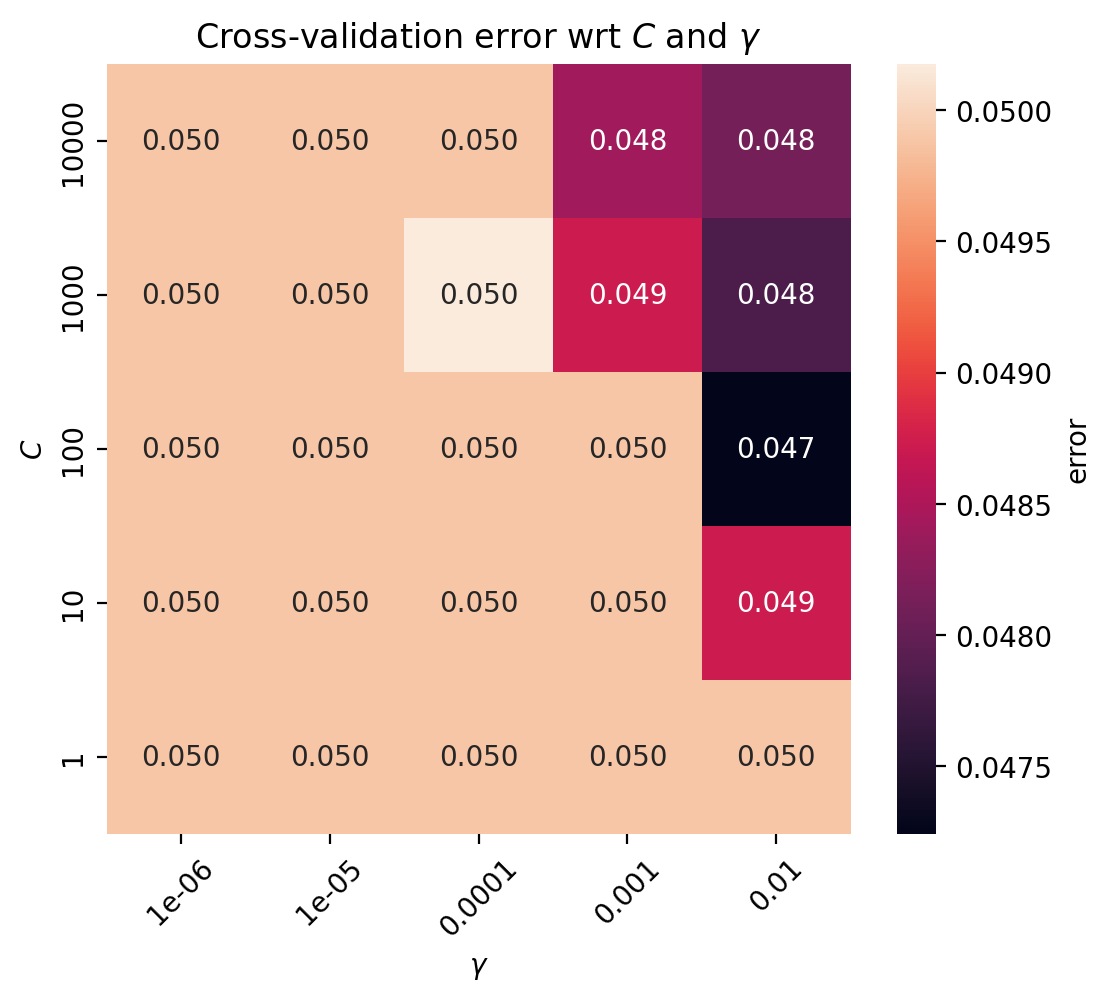

Best CV error = 0.047242497448551156
C* = 100
gamma* = 0.01
Training error using optimal classifier = 0.04988262910798125
Test error using optimal classifier = 0.014662756598240456


In [6]:
C_list = [1, 10, 100, 1000, 10000]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3,1e-2]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros((len(C_list), len(gamma_list)))

best_error = 1.0
opt_C = None
opt_gamma = None
opt_classifier = None

for i, C in enumerate(C_list):
    for j, gamma in enumerate(gamma_list):

        fold_errors = []

        for train_index, val_index in kf.split(X_train):
            X_tr, X_va = X_train[train_index], X_train[val_index]
            Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_va = scaler.transform(X_va)
            
            clf = svm.SVC(C=C, gamma=gamma, kernel='rbf')
            clf.fit(X_tr, Y_tr)

            fold_errors.append(calc_error(X_va, Y_va, clf))

        cv_error = np.mean(fold_errors)
        cv_errors[i,j] = cv_error

        if cv_error < best_error:
            best_error = cv_error
            opt_C = C
            opt_gamma = gamma

opt_classifier = svm.SVC(C=opt_C, gamma=opt_gamma, kernel='rbf')
opt_classifier.fit(X_train, Y_train)

draw_heatmap(cv_errors, gamma_list, C_list)

train_error = calc_error(X_train, Y_train, opt_classifier)
test_error = calc_error(X_test, Y_test, opt_classifier)
print("Best CV error =", best_error)
print("C* =", opt_C)
print("gamma* =", opt_gamma)
print("Training error using optimal classifier =", train_error)
print("Test error using optimal classifier =", test_error)

In [7]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:5455]                         # Shape: (5455, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:5455]                         # Shape: (5455, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[5455:]                         # Shape: (1364, 2)
Y_test  = Y[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5454, 2)
(5454,)
(1364, 2)
(1364,)


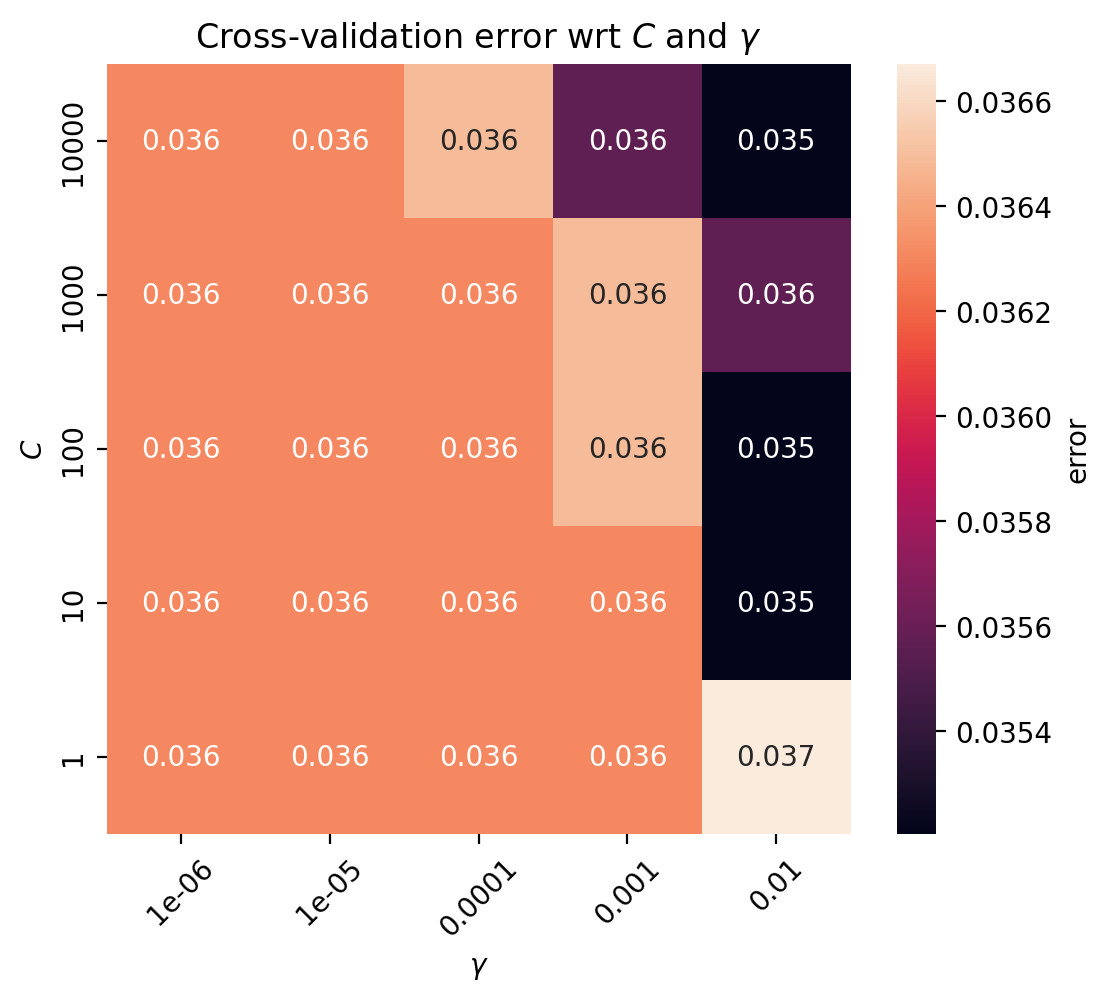

Best CV error = 0.035204466906045284
C* = 100
gamma* = 0.01
Training error using optimal classifier = 0.0363036303630363
Test error using optimal classifier = 0.016129032258064502


In [8]:
C_list = [1, 10, 100, 1000, 10000]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3,1e-2]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros((len(C_list), len(gamma_list)))

best_error = 1.0
opt_C = None
opt_gamma = None
opt_classifier = None

for i, C in enumerate(C_list):
    for j, gamma in enumerate(gamma_list):

        fold_errors = []

        for train_index, val_index in kf.split(X_train):
            X_tr, X_va = X_train[train_index], X_train[val_index]
            Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_va = scaler.transform(X_va)
            
            clf = svm.SVC(C=C, gamma=gamma, kernel='rbf')
            clf.fit(X_tr, Y_tr)

            fold_errors.append(calc_error(X_va, Y_va, clf))

        cv_error = np.mean(fold_errors)
        cv_errors[i,j] = cv_error

        if cv_error < best_error:
            best_error = cv_error
            opt_C = C
            opt_gamma = gamma

opt_classifier = svm.SVC(C=opt_C, gamma=opt_gamma, kernel='rbf')
opt_classifier.fit(X_train, Y_train)

draw_heatmap(cv_errors, gamma_list, C_list)

train_error = calc_error(X_train, Y_train, opt_classifier)
test_error = calc_error(X_test, Y_test, opt_classifier)
print("Best CV error =", best_error)
print("C* =", opt_C)
print("gamma* =", opt_gamma)
print("Training error using optimal classifier =", train_error)
print("Test error using optimal classifier =", test_error)

## Decision Tree - Buntine tree ID3 (using Scikit-Learn) ##

In [9]:
%config InlineBackend.figure_format = 'retina'
import scipy.io as sio
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [10]:
# Draw heatmaps for result of grid search
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='max depth D')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [11]:
# 20-80 partition
  
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:1363]                         # Shape: (1363, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:1363]                         # Shape: (1363, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[1363:]                         # Shape: (5456, 2)
Y_test  = Y[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1362, 2)
(1362,)
(5456, 2)
(5456,)


In [12]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


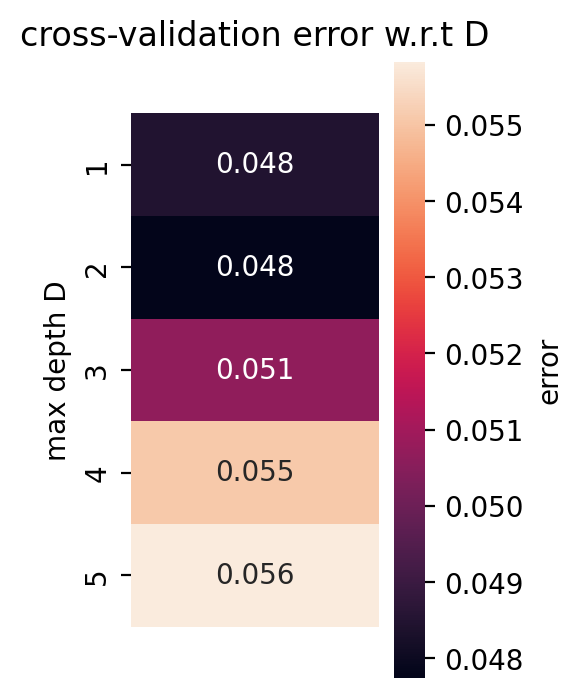

Best max depth D: 2
Training error = 0.04405286343612336
Cross-validated validation error = 0.047740446543580894
Testing error = 0.04398826979472137


In [13]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

In [14]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:3409]                         # Shape: (3409, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:3409]                         # Shape: (3409, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[3409:]                         # Shape: (3410, 2)
Y_test  = Y[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3408, 2)
(3408,)
(3410, 2)
(3410,)


In [15]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


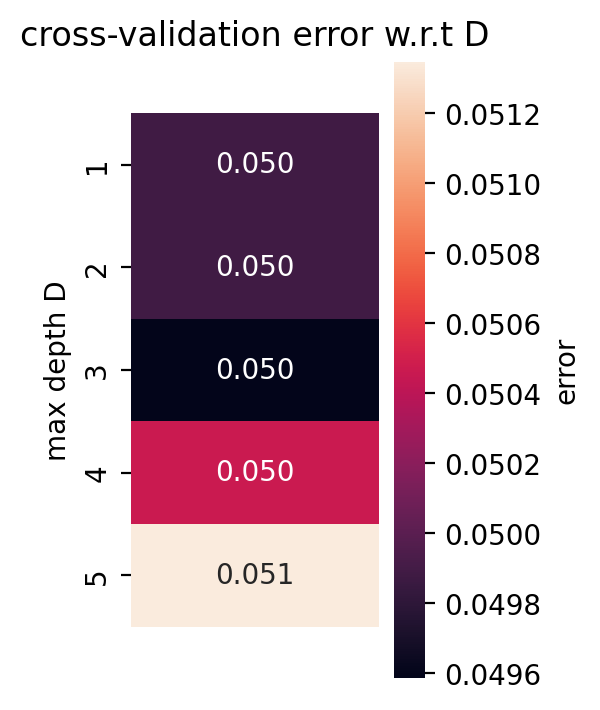

Best max depth D: 3
Training error = 0.046654929577464754
Cross-validated validation error = 0.04958599275487319
Testing error = 0.021994134897360684


In [16]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

In [17]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:5455]                         # Shape: (5455, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:5455]                         # Shape: (5455, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[5455:]                         # Shape: (1364, 2)
Y_test  = Y[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5454, 2)
(5454,)
(1364, 2)
(1364,)


In [18]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


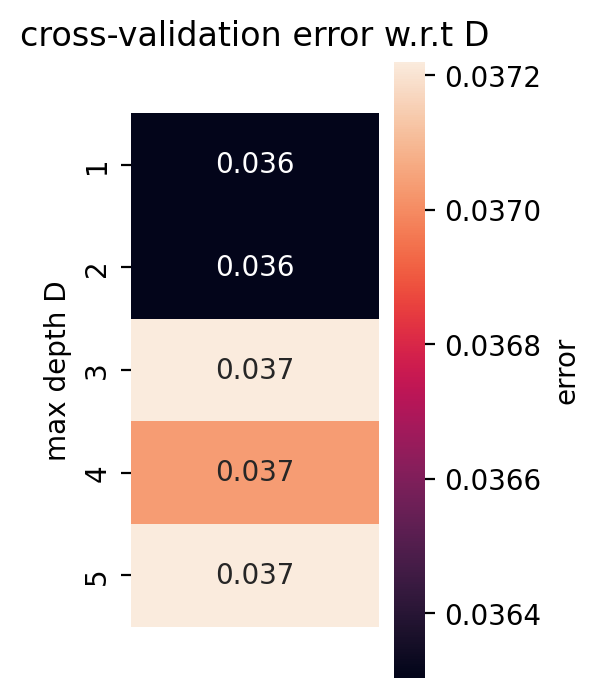

Best max depth D: 1
Training error = 0.0363036303630363
Cross-validated validation error = 0.03630339079880385
Testing error = 0.016129032258064502


In [19]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

## Random Forests ##

In [20]:
# 20-80 partition
 
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:1363]                         # Shape: (1363, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:1363]                         # Shape: (1363, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[1363:]                         # Shape: (5456, 2)
Y_test  = Y[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1362, 2)
(1362,)
(5456, 2)
(5456,)


In [21]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=1
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 2


In [22]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.05875350140056024
Test error = 0.03977272727272729


In [23]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:3409]                         # Shape: (3409, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:3409]                         # Shape: (3409, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[3409:]                         # Shape: (3410, 2)
Y_test  = Y[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3408, 2)
(3408,)
(3410, 2)
(3410,)


In [24]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=1
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 1


In [25]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.05692422304614997
Test error = 0.019648093841642233


In [26]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df[[' Net Income to Total Assets', ' Debt ratio %']].to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

# Original dataset has 6819 instances
X_train = X[:5455]                         # Shape: (5455, 2)
X_train = np.delete(X_train, 45, axis=0)   # Remove a point for separability
Y_train = Y[:5455]                         # Shape: (5455, )
Y_train = np.delete(Y_train, 45, axis=0)   # Remove a point for separability
X_test  = X[5455:]                         # Shape: (1364, 2)
Y_test  = Y[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5454, 2)
(5454,)
(1364, 2)
(1364,)


In [27]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=1
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 2


In [28]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.03960342754311752
Test error = 0.019061583577712593
